## Problem Statement

While traditional methods for alerting on events such as hurricanes and tornadoes rely on information derived from official sources (e.g. USGS), this project aims to utilize Twitter activity to identify such an event. In practice, once the event is predicted, an alert can then be sent out across social media. The outcome of this project will be a binary classification model that can analyze tweets and use them to predict whether a disaster is present and a warning must be sent. As a proof of concept, this project will use archived tweets collected during the most dangerous days of Hurricane Sandy in 2012. The project's terminology will center around that of hurricanes specifically. In this situation, predicting no emergency while a hurricane approaches (false negative) is a much more dangerous outcome than predicting a hurricane when there is none (false positive). Models will therefore be evaluated on recall as well as accuracy.

## Executive Summary

### Data Acquisition

I initially atttempted to use Twitter's API to collect live data. I also tried to use tweet IDs from archived datasets to obtain exact data on the location and datetime of each tweet. This only yielded a small amount of data, not enough to for prediciton. For the scope of this project, I needed a time-efficient solution. I decided to take CrisisLex's dataset of archived tweets during Hurricane Sandy and use them to predict the presence of a hurricane. CrisisLex is a repository of social media data on various crises and natural disasters. This dataset consists of tweets taken from late October 2012, posted by users in coastal New York and New Jersey, and based on 4 keywords: hurricane, hurricane sandy, frankenstorm, and #sandy. One columns lists tweets as "on-topic" or "off-topic", meaning their relevance or irrelevance to the subject of the hurricane. This column is the basis of my binary classification.

### Data Cleaning and EDA

In this dataset, duplicated rows in the "tweets" column would refer to retweets. These rows are dropped so that tweets are not counted more than once, which would give some predictive words too much weight, leading to potential bias in the model. The positive class is the presence of a hurricane, so I set "on-topic" to 1 and "off-topic" to 0. I vectorized the corpus of tweets, and observed the most common words across the entire corpus and between the two classes. Irrelevant words from the positive class were added to the list of stop words to ensure that it was distinct from the negative class. I then used a clustering model to view the overlap between the two classes.

### Modeling

I started with logistic regression models to see if a simpler model would suffice. Following that, I used random forest models to determine if more complexity would lead to more accurate predictions, but these models underperformed. I also experimented with two different methods of vectorizing the tweets. As I conducted EDA, I added words to the list of stop words and re-examined the four models with various versions of the list. This did not have a marked effect on the models' performance. I selected the logistic regression model with CountVectorizer for its accuracy and low variance compared to the random forest models. The recall score of this model is high, meaning that false negatives are kept to a minimum. The strongest feature coefficients of this model correspond with words that are highly relevant to a hurricane. This includes direct references to the event and also to safety precautions taken during a disaster.

## Loading Libraries and Data

In [366]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
set(stopwords.words('english'));

%matplotlib inline

In [269]:
df = pd.read_csv('data/2012_Sandy_Hurricane-ontopic_offtopic.csv')

In [270]:
df.head()

,tweet id,tweet,label
0,'262596552399396864',I've got enough candles to supply a Mexican fa...,off-topic
1,'263044104500420609',Sandy be soooo mad that she be shattering our ...,on-topic
2,'263309629973491712',@ibexgirl thankfully Hurricane Waugh played it...,off-topic
3,'263422851133079552',@taos you never got that magnificent case of B...,off-topic
4,'262404311223504896',"I'm at Mad River Bar &amp; Grille (New York, N...",off-topic


In [271]:
df.shape

(10008, 3)

## Data Cleaning and Preliminary EDA

### Checking Data Types

In [274]:
df.dtypes

tweet id     int64
 tweet      object
 label      object
dtype: object

### Removing Duplicate Rows and Nulls

In [277]:
df.describe(include='object')

,tweet,label
count,10008,10008
unique,9431,2
top,"RT @HurricaneSandyw: FOR EVERY 100 RETWEETS, W...",on-topic
freq,28,6138


In [278]:
df.drop_duplicates(['tweet'], inplace=True)
df.describe(include = 'object')

,tweet,label
count,9431,9431
unique,9431,2
top,Well that was an easy 13 points #Giants,on-topic
freq,1,5579


Duplicates in the tweet column are most likely to be retweets. I wanted to avoid duplicated Twitter content in case it artificially inflated either the 'hurricane' or 'no hurricane' class, which could lead to bias in the model.

In [279]:
df.isnull().sum()

tweet id    0
tweet       0
label       0
dtype: int64

### Renaming Classes

In [280]:
df.replace(to_replace = ["off-topic", "on-topic"], value =[0, 1], inplace=True)

In [281]:
df.head()

,tweet id,tweet,label
0,262596552399396864,I've got enough candles to supply a Mexican fa...,0
1,263044104500420609,Sandy be soooo mad that she be shattering our ...,1
2,263309629973491712,@ibexgirl thankfully Hurricane Waugh played it...,0
3,263422851133079552,@taos you never got that magnificent case of B...,0
4,262404311223504896,"I'm at Mad River Bar &amp; Grille (New York, N...",0


This dataset labels tweet irrelevant to hurricanes as "off-topic" and those relevant as "on-topic". I have turned these into my binary classes, with the positive class indicating the prediction of a hurricane.

In [282]:
df.to_csv('data/sandy.csv', index=False)

## EDA

### Examining and Visualizing Common Words

In [299]:
X = df['tweet']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

cvec = CountVectorizer(ngram_range = (1,2),
                       stop_words = 'english')
X_train = cvec.fit_transform(X_train)
X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=cvec.get_feature_names())
X_train_df

,00,00 00,00 59,00 est,00 gmt,00 humidity,00 ing,00 packing,00 pm,00 year,...,zxnhdkzl,zxntguka,zyhwl7lf,zyhwl7lf youtube,zz5vp7zr,zz5vp7zr hurry,zzcr2jei,zzlxukbm,zzvftd8r,zzxgabhw
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7068,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7069,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Most Common Words Overall')

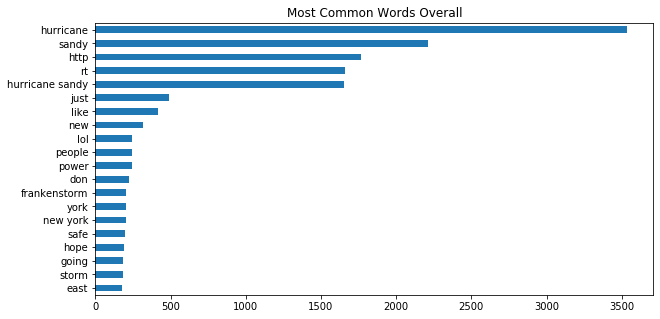

In [355]:
X_train_df.sum().sort_values(ascending = False).head(50) 

top_words = (X_train_df.sum().sort_values(ascending = False).head(20))
plt.figure(figsize=(10,5))
top_words.sort_values(ascending=True).plot(kind='barh')
plt.title('Most Common Words Overall')

Words related to hurricanes are the most common across both classes, as are general Twitter terms 'rt'(retweet), 'like', and 'lol'. These tweets were acquired in part by searching using 'hurricane' as a keyword, so it is possible that we may have unbalanced classes in favor of the positive.

In [285]:
positive = df[df['label'] == 1]
negative = df[df['label'] == 0]

In [336]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['rt', 'http', 'just', 'like', 'new', 'people', 'school', 'hope', 
                  'going', 'to', 'co', 'even', 'go', 'get', 'shit', 'lol', 'would'])

I added to the list of stop words by observing the most common words among the positive dataframe and adding words unrelated to predicting a storm. My aim is to these classes as separable as possible, in order to predict a hurricane more accurately.

In [337]:
X = positive['tweet']
y = positive['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

cvec = CountVectorizer(ngram_range = (1,2),
                       stop_words = stopwords)
X_train = cvec.fit_transform(X_train)
X_train_dfp = pd.DataFrame(X_train.toarray(),
                          columns=cvec.get_feature_names())
X_train_dfp

,00,00 est,00 gmt,00 humidity,00 pm,00 today,00 well,000,000 already,000 customers,...,zuury0fs,zvirufd7,zxnhdkzl,zxntguka,zyhwl7lf,zyhwl7lf via,zyp9wwdp,zzcr2jei,zzlxukbm,zzxgabhw
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4180,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4181,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4182,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Most Common Words - Positive')

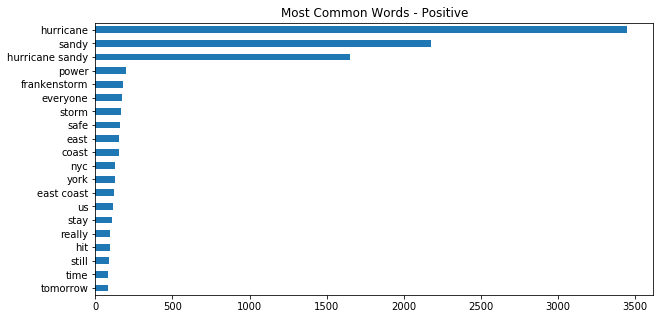

In [356]:
top_positive = (X_train_dfp.sum().sort_values(ascending = False).head(20))
plt.figure(figsize=(10,5))
top_positive.sort_values(ascending=True).plot(kind='barh')
plt.title('Most Common Words - Positive')

After iteratively removing unrelated terms, the most common words now refer to a hurricane specifically, the place it will happen, and certain actions that people or the hurricane itself may take during this time. There is a clear dip in frequency after the first three terms, as many of the most frequent words were irrelevant to our prediction.

In [316]:
X = negative['tweet']
y = negative['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

cvec = CountVectorizer(ngram_range = (1,2),
                       stop_words = stopwords)
X_train = cvec.fit_transform(X_train)
X_train_dfn = pd.DataFrame(X_train.toarray(),
                          columns=cvec.get_feature_names())
X_train_dfn

,00,00 gmt,00 humidity,000,000 dollars,05,05 billion,05 bus,05 thuglife,06,...,zqu,zqzv3atn,zrikpxda,zstsmmbt,ztbaidze,ztvfj5dx,zula7ivv,zwbr1gcc,zxl85vfn,zzvftd8r
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2884,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2885,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Most Common Words - Negative')

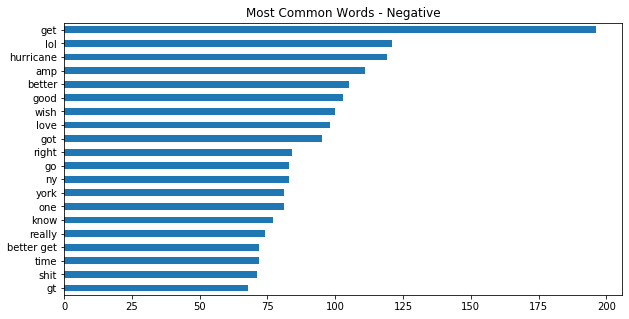

In [357]:
top_negative = (X_train_dfn.sum().sort_values(ascending = False).head(20))
plt.figure(figsize=(10,5))
top_negative.sort_values(ascending=True).plot(kind='barh')
plt.title('Most Common Words - Negative')

The common words in the negative class cannot be used to predict a hurricane, except for the third most frequent word. These words tend to be common words with no distinct subject connecting them, making them fit to sort into the negative class.

### KMeans Clustering

In this section, I use clustering to see the separation between the two classes. Ideally, the resulting clusters should be a noticeable difference apart.

In [358]:
tvec = TfidfVectorizer(stop_words=stopwords)
tvec.fit(df['tweet'].values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [359]:
features = tvec.transform(df['tweet'].values)

In [360]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [361]:
preds = kmeans.predict(features)
kmeans.labels_

array([0, 1, 0, ..., 0, 1, 1], dtype=int32)

In [362]:
kmeans.cluster_centers_

array([[2.85285382e-04, 1.70851504e-04, 8.46589622e-05, ...,
        0.00000000e+00, 8.57080147e-05, 0.00000000e+00],
       [7.75644351e-04, 9.24964070e-04, 0.00000000e+00, ...,
        1.61189790e-04, 0.00000000e+00, 1.41906341e-04]])

In [363]:
pca = PCA(n_components=2, random_state=42) # Code from Sanjaya Subedi
reduced_features = pca.fit_transform(features.toarray())

I have turned the classes into PCA features in order to make them visible on a 2-dimensional scale.

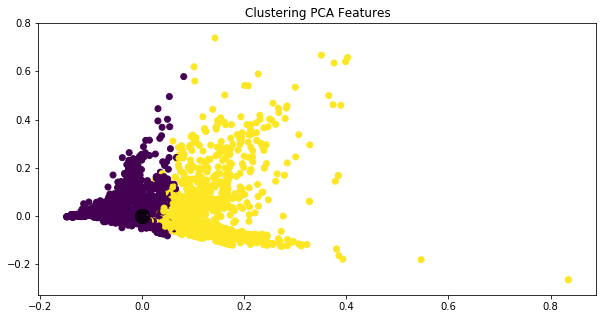

In [364]:
plt.figure(figsize=(10,5))
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=kmeans.predict(features))
plt.title('Clustering PCA Features')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [365]:
silhouette_score(features, kmeans.labels_)

0.0025515058517568134

Although this process results in two distinct clusters, there is no space between them. This is shown both by the overlap between the two clusters and the low silhouette score. The lack of separation is somewhat surprising, given the distinctions between common words of the two classes. It is clear that a supervised classification model is necessary to distinguish between the two classes.